In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import re
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# Part 1 Pre-Processing

## Category of Risk

| category  | description       |
|-----------|-------------------|
| technical | 系统/技术故障，如崩溃、报错    |
| payment   | 扣费异常、支付失败         |
| delivery  | 配送延误、丢件、送错货等      |
| account   | 账号冻结、登录失败、权限问题    |
| service   | 客服响应慢、客服态度差等      |
| pricing   | 价格争议、不一致          |
| legal     | 版权、虚假宣传、数据泄露、违法行为 |

## Labeling Keywords

| Label     | Keywords                                            |
|-----------|-----------------------------------------------------|
| technical | bug, issue, problem, error, app, crash, support     |
| payment   | charge, refund, billing, payment, money, card       |
| delivery  | shipping, delivery, not arrived, late, order        |
| account   | login, locked, password, access, reset              |
| service   | customer service, rude, slow response, support team |
| pricing   | price, expensive, charged, discount, cost           |
| legal     | policy, terms, scam, privacy, legal, misleading     |

## Labeling Sample

| seq | text                                                                                                                                                         | label     |
|-----|--------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------|
| 74  | @116062: will you create a “disaster registry” where fire victims can pick the items they need and anyone can fill them? Offer discounts?                    | pricing   |
| 75  | "@AppleSupport Freezing basically all of the time. Apps are messing up, if i turn on airplane mode and then turn it off i can’t get service without restart" | technical |
| 76  | @VirginTrains I’ve lost my tkt back to Wilmslow. I’ve got receipt and it’s on my app but your staff tell me too bad. Surely not right??                      | technical |
| 77  | @AmazonHelp I ordered a package to be delivered tomorrow but I’ve had a notification saying it’ll be a day late now                                          | delivery  |
| 78  | "@AmazonHelp prime membership says it’s suspended, updated payment method but still says it’s suspended? How do I fix it to get Prime back?"                 | payment   |


In [4]:
df_origin = pd.read_csv("../assets/labeled_L2__sample_enum.csv")
df_origin.head(10)

,tweet_id,text,label
0,2460800,"@704611 Hi Mike, can you give us a little more...",technical
1,1638473,@221850 @17344 @17345 We're aware of this prin...,technical
2,2864565,"@795659 Hi Kyle, we’re so sorry to hear this. ...",technical
3,2842751,@708320 Check out the next article to troubles...,technical
4,1778347,@AskPlayStation do you have an outage. I'm not...,technical
5,2339135,@Ask_WellsFargo I've been on the phone 4 sever...,technical
6,1611732,@MicrosoftHelps any tips on how avoid bsod? I'...,technical
7,1317944,@427830 Hi! Let's work on this together. Which...,technical
8,49697,Disappointed w #Target this morning. @125066 #...,technical
9,1969694,@ComcastCares\n#mobile_Care this error message...,technical


In [5]:
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"http\S+", "", txt)  # remove URLs
    txt = re.sub(r"@\w+", "", txt)  # remove @handles
    txt = re.sub(r"[^a-z\s]", " ", txt)  # keep only letters and spaces
    txt = re.sub(r"\s+", " ", txt).strip()  # collapse multiple spaces

    return txt

In [6]:
df_origin['clean_text'] = df_origin['text'].astype(str).apply(clean_text)
df_origin.head(10)

,tweet_id,text,label,clean_text
0,2460800,"@704611 Hi Mike, can you give us a little more...",technical,hi mike can you give us a little more informat...
1,1638473,@221850 @17344 @17345 We're aware of this prin...,technical,we re aware of this printing error suzanne and...
2,2864565,"@795659 Hi Kyle, we’re so sorry to hear this. ...",technical,hi kyle we re so sorry to hear this is premier...
3,2842751,@708320 Check out the next article to troubles...,technical,check out the next article to troubleshoot the...
4,1778347,@AskPlayStation do you have an outage. I'm not...,technical,do you have an outage i m not the only one get...
5,2339135,@Ask_WellsFargo I've been on the phone 4 sever...,technical,i ve been on the phone several hrs this mornin...
6,1611732,@MicrosoftHelps any tips on how avoid bsod? I'...,technical,any tips on how avoid bsod i m getting loads o...
7,1317944,@427830 Hi! Let's work on this together. Which...,technical,hi let s work on this together which version o...
8,49697,Disappointed w #Target this morning. @125066 #...,technical,disappointed w target this morning snesclassic...
9,1969694,@ComcastCares\n#mobile_Care this error message...,technical,mobile care this error message comes up when i...


# Part 2 Feature Engineering


- 使用 TF-IDF 向量化文本
- 采用 装袋（Bagging）策略
  - 从主数据中随机采样10组子集
  - 每组单独构造一个 TF-IDF 特征空间
  - 每组都可作为一次训练任务

In [7]:
# 停用词处理

stop_words = text.ENGLISH_STOP_WORDS.copy()

additional_stop_words = [
    'rt', 'https', 'co', 'my', 'i',
    'the', 'to', 'and', 'is', 'for',
    'you', 'but', 'we', 'that', 'this'
]
stop_words = stop_words.union(additional_stop_words)

tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b\w+\b",
    max_features=1000
)

In [8]:
# Bagging Optional
def generate_bagged_tfidf_sets(
        df, 
        text_col='clean_text', 
        label_col='label', 
        n_bags=10, 
        sample_frac=0.7, 
        max_features=1000, 
        stop_words=None, 
        random_state=42):
    """
    从清洗后的df中采样构造TF-IDF特征组，用于Bagging建模。
    返回：X_list（稀疏矩阵列表）, y_list（标签数组列表）
    """
    X_list = []
    y_list = []
    
    # if stop_words is None:
    #     from sklearn.feature_extraction import text
    #     stop_words = text.ENGLISH_STOP_WORDS.union({
    #         'rt', 'https', 'co', 'my', 'i', 'the', 'to', 'and', 'is', 'for', 'you', 'but', 'we', 'that', 'this'
    #     })

    label_encoder = LabelEncoder()
    df = df.copy()
    df[label_col] = label_encoder.fit_transform(df[label_col].astype(str))

    for i in range(n_bags):
        df_sample = df.sample(frac=sample_frac, random_state=random_state + i)
        tfidf = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
        X = tfidf.fit_transform(df_sample[text_col])
        y = df_sample[label_col].values

        X_list.append(X)
        y_list.append(y)

    return X_list, y_list, label_encoder.classes_

In [94]:
# 10组稀疏特征训练集
X_list, y_list, label_names = generate_bagged_tfidf_sets(df_origin)

# Part 3 Training & Testing

| category of risk            | description                     |
|-----------------------------|---------------------------------|
| technical                   | 系统/技术故障，如崩溃、报错                  |
| payment                     | 扣费异常、支付失败                       |
| delivery                    | 配送延误、丢件、送错货等                    |
| account                     | 账号冻结、登录失败、权限问题                  |
| service                     | 客服响应慢、客服态度差等                    |
| pricing                     | 价格争议、不一致                        |
| legal                       | 版权、虚假宣传、数据泄露、违法行为               |



In [9]:
X = tfidf.fit_transform(df_origin['clean_text'])

le = LabelEncoder()
y = le.fit_transform(df_origin['label'].values)

In [10]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    test_size=0.2, 
    random_state=42
)

# 模型训练
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

/Users/Matthew/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:57:56] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.90      0.99      0.95       420
           2       1.00      0.50      0.67        40
           3       0.99      0.96      0.97       300
           4       0.89      0.80      0.84        30
           5       0.94      0.97      0.96       240
           6       0.98      0.95      0.97       360

    accuracy                           0.95      1450
   macro avg       0.96      0.87      0.90      1450
weighted avg       0.95      0.95      0.95      1450



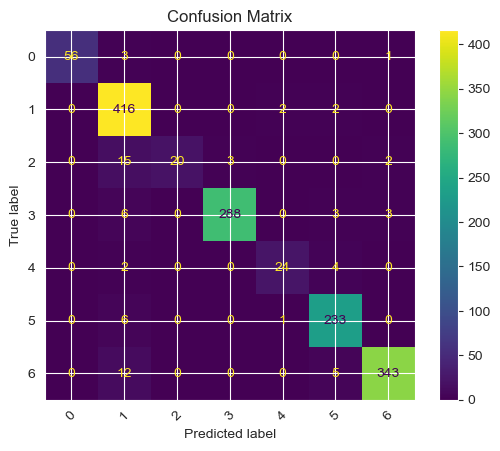

In [11]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# 软换标签由编码到文字
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.ax_.set_title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()